In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = 'data/plant_classification/'

In [4]:
arch = resnet50

In [16]:
def get_data(sz, bs=64):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, test_name='test')
    return data

## Show random images from dataset in grid w/ titles

In [23]:
data = get_data(224)

In [24]:
ds = data.trn_ds.fnames

In [32]:
def plots(ims, figsize=None, rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('On')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
def load_img_id(ds, path): return np.array(PIL.Image.open(PATH+path))

def rand_imgs(ds, num):
    paths = np.random.choice(ds, num, replace=False)
    imgs = [load_img_id(ds,p) for p in paths]
    titles = np.array([t[6:-14] for t in paths])
    rows = -(-num//4)
#     upside down floor division -> ceiling division  https://stackoverflow.com/a/17511341
    return plots(imgs, rows=rows, titles=titles, figsize=(16,8))

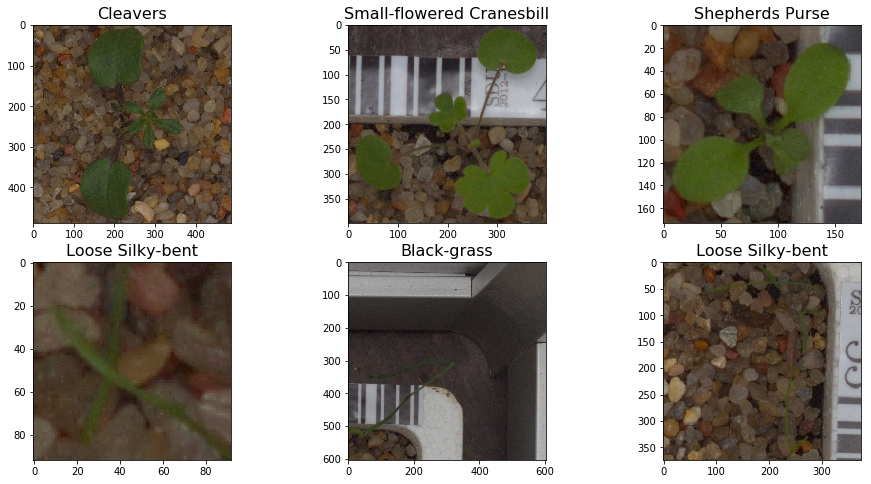

In [33]:
rand_imgs(data.trn_ds.fnames, 6)

### Determine sizes

((array([ 3228.,  1149.,   267.,    77.,    15.,     6.,     3.,     3.,     0.,     2.]),
  array([   49. ,   443.2,   837.4,  1231.6,  1625.8,  2020. ,  2414.2,  2808.4,  3202.6,  3596.8,  3991. ]),
  <a list of 10 Patch objects>),
 (array([ 2920.,  1318.,   332.,   122.,    36.,    13.,     3.,     3.,     0.,     3.]),
  array([   49. ,   389.8,   730.6,  1071.4,  1412.2,  1753. ,  2093.8,  2434.6,  2775.4,  3116.2,  3457. ]),
  <a list of 10 Patch objects>))

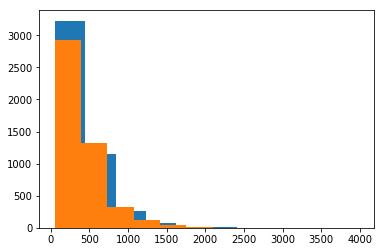

In [36]:
# create a dictionary comprehension of image sizes in the dataset
size_dist = {k: PIL.Image.open(PATH+k).size for k in ds}

row_sz,col_sz = list(zip(*size_dist.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

plt.hist(row_sz), plt.hist(col_sz)

In [38]:
np.mean(row_sz), np.mean(col_sz)

(371.46589473684213, 370.7301052631579)

In [39]:
np.median(row_sz), np.median(col_sz)

(266.5, 266.5)

### Show examples of data transformations

In [91]:
sz = 256
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, bs=1, tfms=tfms, num_workers=2)

In [84]:
def get_augs(data):
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[0]

def rand_aug_imgs(data, num=6):
    imgs = np.stack([get_augs(data) for i in range(num)])
    rows = -(-num//4)
    plots(imgs, rows=rows, figsize=(16,8))

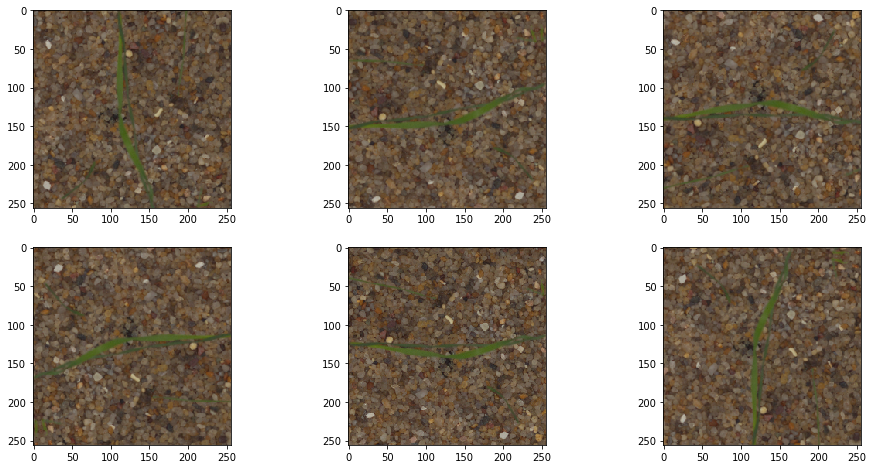

In [88]:
# top down
rand_aug_imgs(data, 6)

## Training

In [17]:
learn = ConvLearner.pretrained(arch, get_data(128))

In [64]:
learn.fit(1e-2, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

[ 0.       1.52678  0.96725  0.68646]                     
[ 1.       1.17674  0.79351  0.74219]                     
[ 2.       1.01429  0.72524  0.75625]                     
[ 3.       0.92568  0.64151  0.78646]                      
[ 4.       0.86344  0.60929  0.80573]                      



In [19]:
lr = 1e-2
lrs = np.array([lr/9, lr/3, lr])

In [66]:
learn.unfreeze()

In [67]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.52678  0.39147  0.86979]                      
[ 1.       0.36312  0.24405  0.91563]                      
[ 2.       0.2532   0.2377   0.91042]                      
[ 3.       0.21501  0.16623  0.94531]                      
[ 4.       0.17186  0.14651  0.95625]                      
[ 5.       0.13136  0.11234  0.96406]                      
[ 6.       0.10993  0.10752  0.96719]                      



In [68]:
learn.save('128_v2')

In [69]:
learn.set_data(get_data(256))

In [70]:
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.22652  0.2476   0.91875]                      
[ 1.       0.18548  0.21915  0.925  ]                      
[ 2.       0.16731  0.21008  0.92969]                      



In [71]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('256_v2')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.17745  0.12831  0.9625 ]                      
[ 1.       0.16843  0.16501  0.94375]                      
[ 2.       0.11328  0.09052  0.96875]                      
[ 3.       0.10125  0.08441  0.97344]                      
[ 4.       0.07709  0.06995  0.97656]                       
[ 5.       0.06336  0.05553  0.98281]                       
[ 6.       0.05086  0.05795  0.98125]                       



In [93]:
learn.load('256_v2')

In [94]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

## Create csv with results

In [116]:
classes = learn.data.classes
choices = np.argmax(probs, axis=1)
# Returns the indices of the maximum values along an axis

res = []
for i in np.nditer(choices):
    res.append(classes[i])

In [117]:
df = pd.DataFrame(res)

In [118]:
df.insert(0, 'file', [n[5:] for n in learn.data.test_ds.fnames])
# subset the string (remove 'test/')

In [119]:
df.columns = ['file','species']

In [120]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm_v2.csv', index=False)